# Data Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get the nec
from fastai.vision.all import *
from utils import *
import copy
from collections import Counter
path = untar_data(URLs.PETS)

import warnings
warnings.filterwarnings("ignore")

In [3]:
(path/"annotations").ls()
# (path/"annotations"/"list.txt").read_text()

(#7) [Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/list.txt'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/test.txt'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/trimaps'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/xmls'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/README'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/trainval.txt')]

In [4]:
train_val_images = (path/"annotations"/"trainval.txt").read_text().split("\n")

In [5]:
df = pd.DataFrame([x.split(" ") for x in train_val_images if x!=""], columns = ["Image", "ClassId", "Species", "BreedId"])
df.Image = df.Image.apply(lambda x: f"{x}.jpg")
df.tail()

,Image,ClassId,Species,BreedId
3675,yorkshire_terrier_187.jpg,37,2,25
3676,yorkshire_terrier_188.jpg,37,2,25
3677,yorkshire_terrier_189.jpg,37,2,25
3678,yorkshire_terrier_18.jpg,37,2,25
3679,yorkshire_terrier_190.jpg,37,2,25


In [6]:
# 12 cat breeds
df[df.Species == "1"].BreedId.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)

In [7]:
# 25 dog breeds
df[df.Species == "2"].BreedId.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25'], dtype=object)

In [8]:
# 37 total breeds
df.ClassId.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37'], dtype=object)

In [9]:
# Replace class id with class names
df.ClassId = df.Image.apply(lambda x: re.sub(r"_\d+\.jpg", "", x))
df.tail()

,Image,ClassId,Species,BreedId
3675,yorkshire_terrier_187.jpg,yorkshire_terrier,2,25
3676,yorkshire_terrier_188.jpg,yorkshire_terrier,2,25
3677,yorkshire_terrier_189.jpg,yorkshire_terrier,2,25
3678,yorkshire_terrier_18.jpg,yorkshire_terrier,2,25
3679,yorkshire_terrier_190.jpg,yorkshire_terrier,2,25


In [10]:
# Define the getter for independent variable
def get_x(row): return path/"images"/row['Image']

# Define the getter for dependent variable
def get_y(row): return [row['ClassId']]

In [11]:
# Define a multicategory block with presizing
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(valid_pct = 0.25, seed = 42),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(460, min_scale=0.35),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]
                  )

In [12]:
dls = dblock.dataloaders(df, bs = 32)

In [13]:
len(dls.train_ds), len(dls.valid_ds)

(2760, 920)

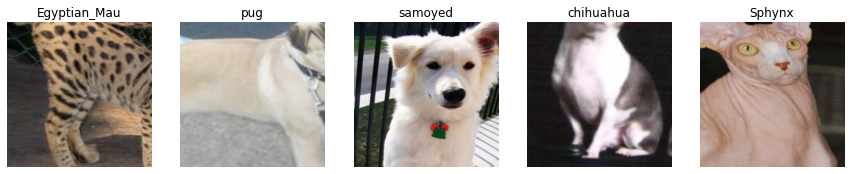

In [14]:
dls.show_batch(nrows=1, ncols=5)

# Model Training

SuggestedLRs(valley=0.00363078061491251)

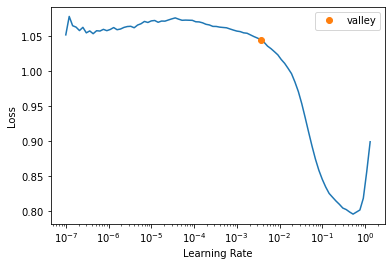

In [15]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.5))
learn.lr_find()

In [16]:
learn.fine_tune(epochs = 5, freeze_epochs = 3, base_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.024620,0.769550,0.539160,00:23
1,0.881714,0.588895,0.696563,00:22
2,0.510702,0.153600,0.983049,00:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.202702,0.094006,0.986633,00:29
1,0.126247,0.050881,0.987485,00:29
2,0.081604,0.035113,0.989659,00:30
3,0.061792,0.030048,0.990570,00:31
4,0.054275,0.028864,0.991216,00:30


In [17]:
learn.export("bceClassification.pkl")

# Threshold selection

In [18]:
predictions, targets = learn.get_preds(reorder = False)

In [19]:
predictions.shape, targets.shape

(torch.Size([920, 37]), torch.Size([920, 37]))

In [20]:
predictions[0], targets[0]

(tensor([0.0020, 0.0074, 0.0038, 0.0022, 0.0049, 0.0036, 0.0144, 0.0046, 0.0030,
         0.0044, 0.0066, 0.0043, 0.0019, 0.0038, 0.0069, 0.0043, 0.0139, 0.0024,
         0.0420, 0.0031, 0.0050, 0.0183, 0.0234, 0.0021, 0.0061, 0.3898, 0.0018,
         0.1271, 0.0050, 0.0088, 0.0151, 0.0014, 0.0038, 0.0037, 0.0140, 0.1003,
         0.0013]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]))

In [21]:
(torch.all((predictions >= 0.5) * 1. == targets, axis = 1)* 1.).mean()

TensorMultiCategory(0.6924)

In [22]:
((predictions >= 0.5) * 1. == targets).float().mean()

TensorMultiCategory(0.9912)

## Global thresholding

In [25]:
def threshold(preds, targets):
    # Define 100 thresholds equally spaced from 0 to 1
    thresholds = np.arange(0, 1, 0.01)
    
    # Create a mapping from threshold to accuracies
    thresholdAccuracyMapping = {}
    for thresh in thresholds:
        thresholdAccuracyMapping[thresh] = accuracy_multi(preds, targets, thresh = thresh, sigmoid = False).item()
    
    # Create a dataframe out of the above mapping
    df = pd.DataFrame(thresholdAccuracyMapping, index = ["Accuracy"]).T.reset_index()
    df.columns = ["Threshold", "Accuracy"]

    # Make a plot
    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    sns.lineplot(data = df, x = "Threshold", y = "Accuracy", ax = ax)
    fig.suptitle("Accuracy at different thresholds", fontsize = 24)
    fig.tight_layout();

    # Plot the best threshold
    bestThreshold = df[df.Accuracy == df.Accuracy.max()].reset_index(drop = True).iloc[0, :]
    bestThr = bestThreshold.Threshold.item()
    bestAcc = bestThreshold.Accuracy.item()
    ax.scatter(bestThr, bestAcc, c = "red");

    # Return the best Threshold
    return (bestThr, bestAcc)

(0.36, 0.9924206733703613)

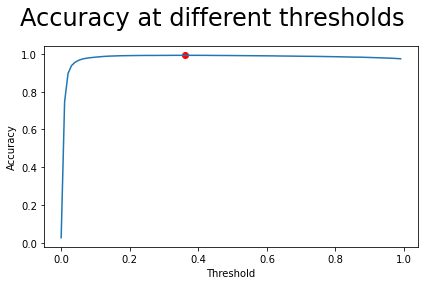

In [26]:
threshold(predictions, targets)

## Local thresholding and then combining

{'bestF1_Point': [0.48, 0.9934782608695653],
 'bestAcc_Point': [0.48, 0.9934782608695653],
 'closest_Point': [0.08, 0.9630434782608696]}

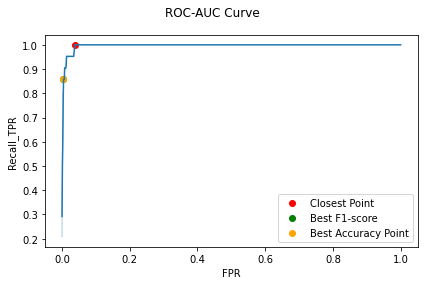

In [28]:
utils.getSummary(predictions[:, 5], targets[:, 5])

In [29]:
# With max accuracy strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "Accuracy")

0.994271457195282

In [30]:
# With max f1Score strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "f1Score")

0.9941833019256592

In [31]:
# With closest point strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "Closest")

0.9836075305938721

# Wrong Examples

In [32]:
thr = 0.36

In [33]:
result = torch.all((predictions >= thr) * 1. == targets, axis = 1)* 1.

In [34]:
errors = torch.where(result == 0.)[0]

In [35]:
all_valid_images = list(dls.valid_ds.items.Image)

In [40]:
predictions[0][25]

tensor(0.3898)

In [48]:
predictions[0].argmax().item()

25

In [64]:
records = []
for error in errors:
    pd_ = torch.where(predictions[error] >= thr)[0]
    name = all_valid_images[error]
    
    if len(pd_):
        cs = [round(predictions[error][x.item()].item(), 3) for x in pd_]
    
    tg = torch.where(targets[error])[0].item()
    
    if len(pd_):
        records.append([name, cs, dls.vocab[tg], [dls.vocab[x] for x in pd_]])
    else:
        most_probable = predictions[error].argmax().item()
        most_probable_class = dls.vocab[most_probable]
        most_probable_class_cs = round(predictions[error][most_probable].item(), 3)
        records.append([name, -1, dls.vocab[tg], [most_probable_class_cs, most_probable_class]])

In [65]:
error_df = pd.DataFrame(records, columns = ["Name", "Conf_Score", "Ground Truth", "Pred/ Alt Pred"])

In [66]:
error_df

,Name,Conf_Score,Ground Truth,Pred/ Alt Pred
0,Maine_Coon_204.jpg,-1,Maine_Coon,"[0.307, Maine_Coon]"
1,american_pit_bull_terrier_101.jpg,-1,american_pit_bull_terrier,"[0.276, american_pit_bull_terrier]"
2,english_cocker_spaniel_176.jpg,[0.489],english_cocker_spaniel,[german_shorthaired]
3,pug_107.jpg,-1,pug,"[0.172, pug]"
4,saint_bernard_140.jpg,-1,saint_bernard,"[0.304, saint_bernard]"
...,...,...,...,...
221,Birman_122.jpg,"[0.749, 0.605]",Birman,"[Birman, Siamese]"
222,basset_hound_158.jpg,-1,basset_hound,"[0.226, beagle]"
223,samoyed_150.jpg,[0.723],samoyed,[great_pyrenees]
224,miniature_pinscher_125.jpg,-1,miniature_pinscher,"[0.337, miniature_pinscher]"


In [67]:
error_df.to_csv("./artefacts/bce_error_df.csv", index = None)